# Exact Floquet-Bloch States and Quasi-Energy Spectrum



In [1]:
import numpy as np
import pandas as pd
from algolab.tbm.tbtmdc import *
from algolab.utils.dynamics import *
from algolab.utils import plotting as PLT
from scipy import special as sp, linalg 
from math import pi, sqrt
from matplotlib import pyplot as plt
from multiprocessing import Pool
%matplotlib inline

## Data

In [2]:
data   = load_tbtable('TBParams_TMDC.csv')
Hterms = tbtable_hterms(data, 'MoS2')
Hterms = symterms(Hterms)
(a1,a2), (b1,b2), (M,K) = lattice_vectors(Hterms)
Hcomp = HamiltonianComp(Hterms)
Nsys = Hcomp.shape[-1]
Nocc = 7
print(Hcomp.shape)
dhop = hopping_vectors(Hterms)
Cmtr = lambda A, B : A @ B - B @ A

(2, 10, 11, 11)


## Circut for Bands

In [3]:
phi = [0, -pi/2]
Avec = np.array([1,1])
a,b = 1/2,1/2
u = np.linspace(0,1,21)
# Gamma --> M
kv1 = u[:,None] * M
# M --> K
kv2 = u[:,None] * K + M * (1-u[:,None])
# K --> Gamma
kv3 = (1-u[:,None]) * K 

q1 = np.sqrt((kv1**2).sum(axis=1))
q2 = q1[-1] + np.sqrt(( (kv2-kv2[0]) **2).sum(axis=1))
q3 = q2[-1] + np.sqrt(( (kv3-kv3[0]) **2).sum(axis=1))
kv = np.vstack((kv1,kv2,kv3))
q  = np.hstack((q1,q2,q3))

E0  = np.vstack([np.linalg.eigvalsh(Hamiltonian_from_comp(Hcomp, dhop, k)) for k in kv])
H   = np.array([Hamiltonian_from_comp(Hcomp, dhop, k) for k in kv])
Vel = np.array([gradk_Hamiltonian(Hcomp, dhop, k) for k in kv])
VA  = Vel[:,0]*exp(1j*phi[0]) + Vel[:,1]*exp(1j*phi[1])

In [268]:
E0 = np.zeros((len(kv),Nsys))
V0 = np.zeros((len(kv),Nsys,Nsys),dtype=complex)
ProjGS = np.zeros_like(V0)
ProjES = np.zeros_like(V0)
ProjGSbasis = np.zeros_like(V0)
ProjESbasis = np.zeros_like(V0)
for i in range(len(ProjGS)):
    ProjGSbasis[i] = np.diag([1]*7+[0]*4)
    ProjESbasis[i] = np.diag([0]*7+[1]*4)
for i,k in enumerate(kv):
    e,v = np.linalg.eig(Hamiltonian_from_comp(Hcomp, dhop, k))
    j = np.argsort(e.real)
    E0[i] = e[j].real
    V0[i] = v[:,j]
    ProjGS[i] = V0[i] @ ProjGSbasis[i] @ V0[i].conj().T
    ProjES[i] = V0[i] @ ProjESbasis[i] @ V0[i].conj().T

def td_states(key,kv,a,phi,E,L):
    HX = bloch_pierels_blocks(Hcomp, dhop, kv, [a, a], phi, max_order=L)
    E,V,U = quasi_energy_spectrum_time_domain(E, HX,trotter_steps=100,return_states=True,return_propagator=True)
    return key,(E,V,U)

def Etd(a,E,L,key=0,t=0.5,wind=True): 
    args = [(i,k,a,phi,E,L) for i,k in enumerate(kv)]
    workers = Pool(14)
    res = workers.starmap(td_states, args)
    _,(W,V,U) = res[0]
    W = np.zeros((len(args),len(W)))
    Psi = np.zeros((len(args),)+V.shape,dtype=complex)
    P   = np.zeros(Psi.shape[:2])
    for i, (w,v,u) in res:
        P[i] = np.abs(np.diag(v.conj().T @ ProjGS[i] @ v))**2
        if wind:
            sel = (w > 0) & (P[i]>t)
            w[sel] = w[sel] - E
            sel = (w < 0) & (P[i]<1-t)
            w[sel] = w[sel] + E
        W[i] = w
        Psi[i] = v
    return W,Psi,P

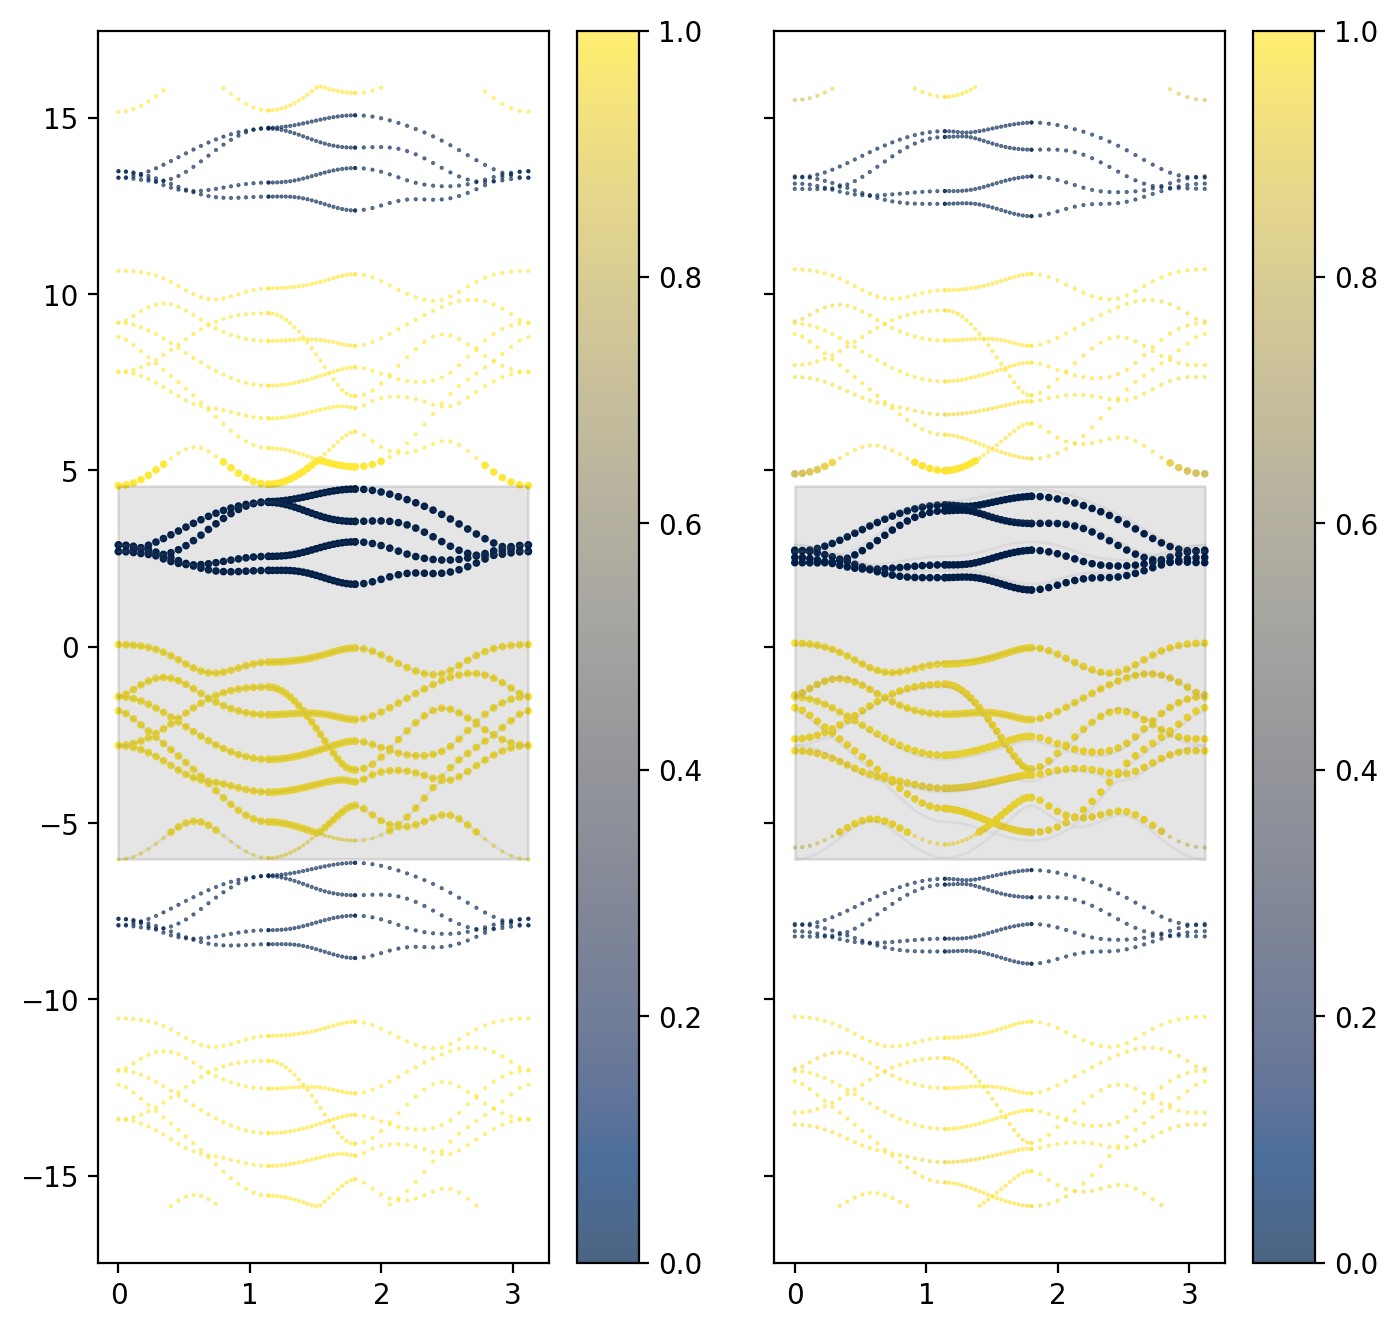

In [286]:
E = 10.6
L = 4
wind=False
data0 = Etd(0.0001,E,L,wind=wind)
data1 = Etd(0.2,E,L,wind=wind)
fig,axs=PLT.subplots(figsize=(8,8),dpi=200,ncols=2,sharex=True,sharey=True)

for i in range(2):
    ax=axs[i]
    data = [data0,data1][i]
    W,Psi,P_ = data
    P  = np.abs(P_)**2
    P0 = np.abs(data0[-1])**2
    W0=data0[0]

    ax.plot(q,E0,'-',color='tab:gray',linewidth=1,alpha=0.1)
    cmap='cividis'
    im=ax.scatter(np.tile(q[:,None],W.shape[1]),W,c=P,s=3,cmap=cmap,vmin=0,vmax=1)
    im=ax.scatter(np.tile(q[:,None],W.shape[1]),W-E,c=P.real,s=1,marker='.',cmap=cmap,vmin=0,vmax=1,alpha=0.7)
    im=ax.scatter(np.tile(q[:,None],W.shape[1]),W+E,c=P.real,s=1,marker='.',cmap=cmap,vmin=0,vmax=1,alpha=0.7)
    ax.fill_between(q[[0,-1]],E0.min(),E0.min()+E,color='k',alpha=0.1,edgecolor='k')
    #ax.set_ylim(E0.min()-1,E0.max()+1)
    fig.colorbar(im,ax=ax)


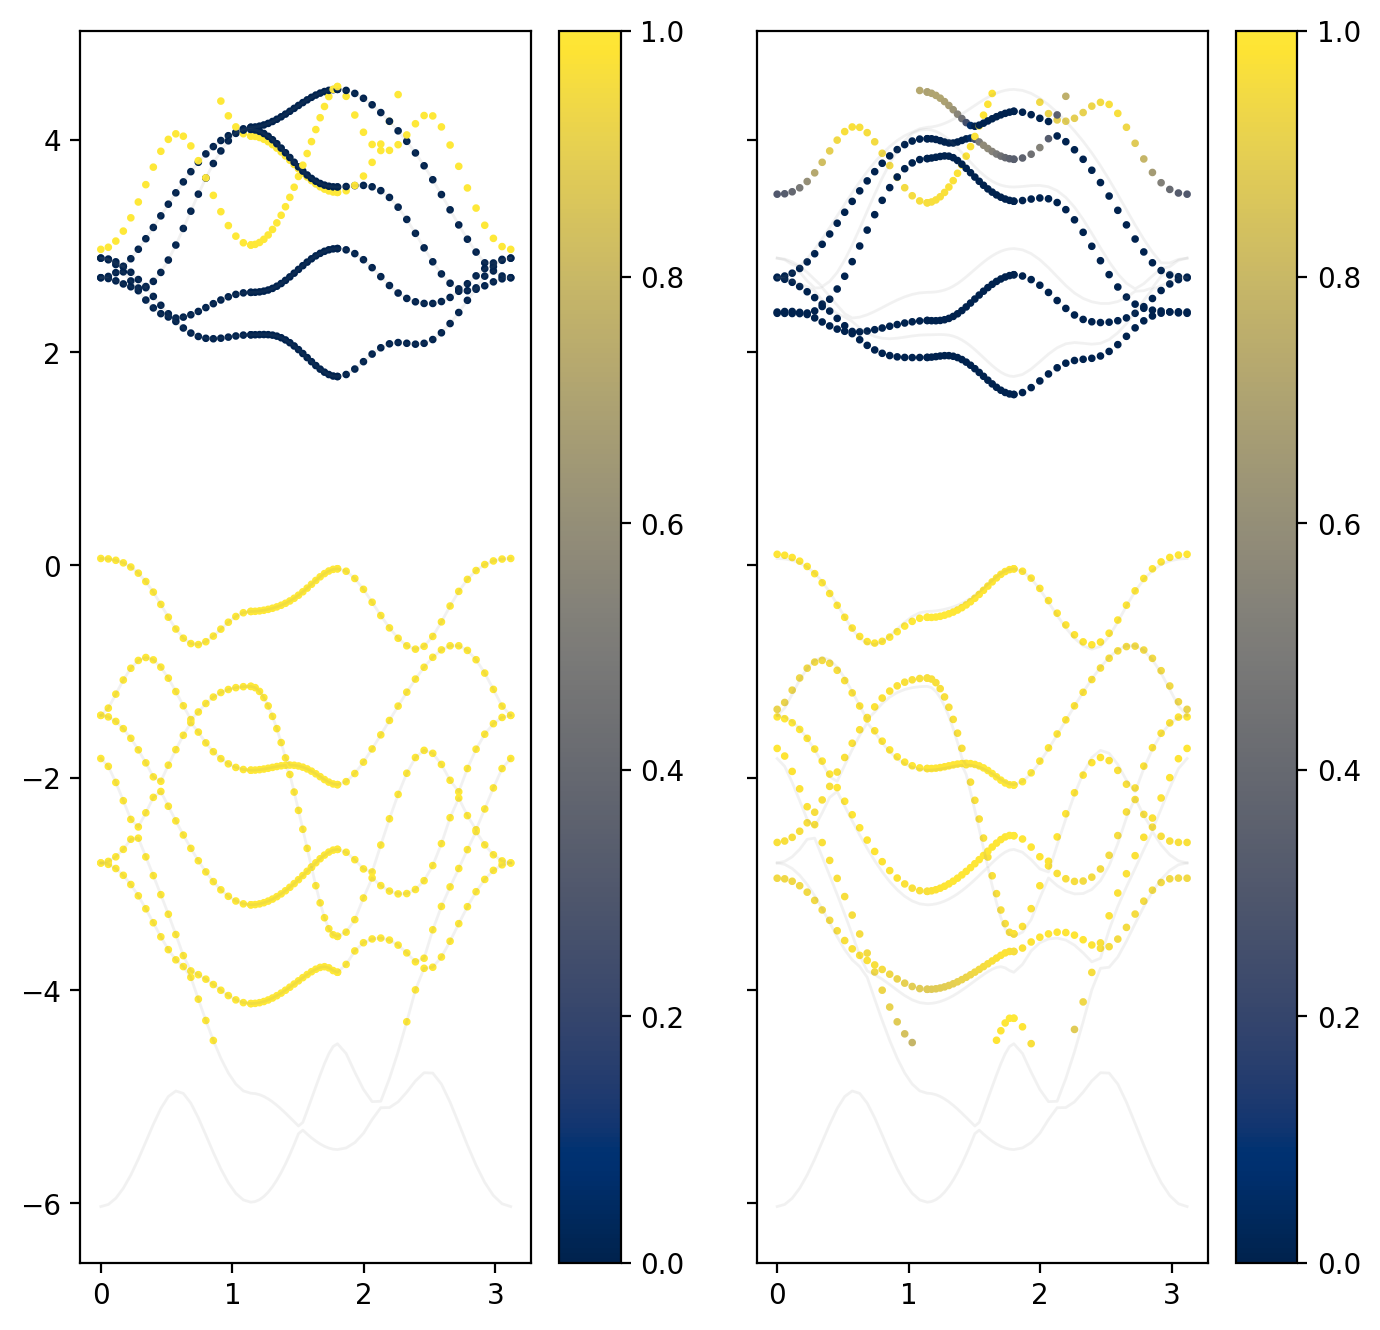

In [297]:
E = 9.0
L = 4
wind=False
data0 = Etd(0.0001,E,L,wind=wind)
data1 = Etd(0.2,E,L,wind=wind)
fig,axs=PLT.subplots(figsize=(8,8),dpi=200,ncols=2,sharex=True,sharey=True)

for i in range(2):
    ax=axs[i]
    data = [data0,data1][i]
    W,Psi,P_ = data
    P  = np.abs(P_)**2
    P0 = np.abs(data0[-1])**2
    W0=data0[0]

    ax.plot(q,E0,'-',color='tab:gray',linewidth=1,alpha=0.1)
    cmap='cividis'
    im=ax.scatter(np.tile(q[:,None],W.shape[1]),W,c=P,s=3,cmap=cmap,vmin=0,vmax=1)
    #im=ax.scatter(np.tile(q[:,None],W.shape[1]),W-E,c=P.real,s=1,marker='.',cmap=cmap,vmin=0,vmax=1,alpha=0.7)
    #im=ax.scatter(np.tile(q[:,None],W.shape[1]),W+E,c=P.real,s=1,marker='.',cmap=cmap,vmin=0,vmax=1,alpha=0.7)
    #ax.fill_between(q[[0,-1]],W0.min(),W0.min()+E,color='k',alpha=0.1,edgecolor='k')
    #ax.set_ylim(E0.min()-1,E0.max()+1)
    fig.colorbar(im,ax=ax)

In [301]:
np.atleast_2d(np.array([[0,1],[1,0]]))

array([[0, 1],
       [1, 0]])